In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.manifold import TSNE

from utils import get_loaders, get_features
from models import SSLNet, DeepSAD
from trainers import train
from evals import evaluate

print(torch.cuda.is_available())

True


# Training DeepSAD

In [37]:
config = {
    'method': 'sad',
    'eta': 10.,
    
    # Training
    'epochs': 1000,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'patience': 20,
    'min_delta': 1e-8,
    'sched_patience': 10,
    'sched_factor': 0.5,
    
    # Network
    'dims' : [30, 16, 16, 8],
    'drop': None,
    'norm': True,
    'activation': 'LeakyReLU',
    
    # Dataset
    'val_split': 0.1,
    'test_split': 0.1,
    'batch_size': 1024,
    
    # Utility
    'seed': 15,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_path': './Data/creditcard.csv',
    'print_freq': 20,
}

In [38]:
train_loader, val_loader, test_loader = get_loaders(config['data_path'], config['val_split'], config['test_split'], config['seed'], config['batch_size'], config['method'])

(230693, 31) (25633, 31) (28481, 31)


In [39]:
if config['method'] == 'ssd':
    model = SSLNet(config).to(config['device'])
else:
    model = DeepSAD(config).to(config['device'])
print(model)
config['seed'] = 15

DeepSAD(
  (embeddings): Sequential(
    (0): Linear(in_features=30, out_features=16, bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=16, out_features=16, bias=False)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=16, out_features=8, bias=False)
  )
)


In [40]:
model, train_losses, val_losses, _, _, _, _ = train(model, train_loader, val_loader, config)

Epoch 1 | Train Loss: 0.6493 | Val Loss: 0.3989 | Train AUPRC: 0.1270 | Val AUPRC: 0.2542 | Train FPR@95TPR: 0.1880 | Val FPR@95TPR: 0.1364 | Best Epoch: 0
Epoch 20 | Train Loss: 0.0657 | Val Loss: 0.1035 | Train AUPRC: 0.7142 | Val AUPRC: 0.8147 | Train FPR@95TPR: 0.0526 | Val FPR@95TPR: 0.1136 | Best Epoch: 15
Early stopping
Epoch 35 | Train Loss: 0.0561 | Val Loss: 0.1277 | Train AUPRC: 0.7216 | Val AUPRC: 0.8215 | Train FPR@95TPR: 0.0426 | Val FPR@95TPR: 0.0909 | Best Epoch: 15
Training completed in 1m 41s


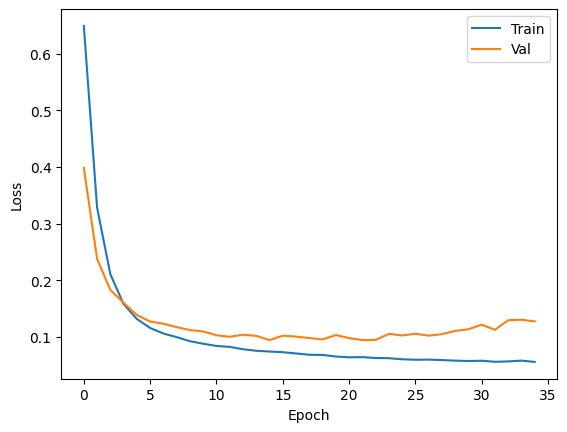

In [41]:
# Plot the loss
plt.plot(train_losses, label = "Train")
plt.plot(val_losses, label = "Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
train_ap, train_fpr, train_roc = evaluate(model, train_loader, train_loader, config['method'])
val_ap, val_fpr, val_roc = evaluate(model, train_loader, val_loader, config['method'])
test_ap, test_fpr, test_roc = evaluate(model, train_loader, test_loader, config['method'])

print(f'Train FPR@95: {train_fpr:.4f}, Val FPR@95: {val_fpr:.4f}, Test FPR@95: {test_fpr:.4f}')
print(f'Train AUPRC: {train_ap:.4f}, Val AUPRC: {val_ap:.4f}, Test AUPRC: {test_ap:.4f}')
print(f'Train ROC: {train_roc:.4f}, Val ROC: {val_roc:.4f}, Test ROC: {test_roc:.4f}')

Train FPR@95: 0.0376, Val FPR@95: 0.0909, Test FPR@95: 0.0816
Train AUPRC: 0.7376, Val AUPRC: 0.8211, Test AUPRC: 0.7603
Train ROC: 0.9954, Val ROC: 0.9555, Test ROC: 0.9717


In [43]:
# Get embeddings
z_train, y_train = get_features(model, train_loader)
z_val, y_val = get_features(model, val_loader)
z_test, y_test = get_features(model, test_loader)

# Sample only 1000 points from normal, but all frauds
n_train = pd.DataFrame(z_train[y_train == 0])
n_val = pd.DataFrame(z_val[y_val == 0])
n_test = pd.DataFrame(z_test[y_test == 0])

n_train = n_train.sample(1000, random_state=15)
n_val = n_val.sample(1000, random_state=15)
n_test = n_test.sample(1000, random_state=15)

z_train = pd.concat([n_train, pd.DataFrame(z_train[y_train == 1])], axis=0).values
z_val = pd.concat([n_val, pd.DataFrame(z_val[y_val == 1])], axis=0).values
z_test = pd.concat([n_test, pd.DataFrame(z_test[y_test == 1])], axis=0).values

y_train = np.concatenate([np.zeros(1000), np.ones(z_train.shape[0] - 1000)])
y_val = np.concatenate([np.zeros(1000), np.ones(z_val.shape[0] - 1000)])
y_test = np.concatenate([np.zeros(1000), np.ones(z_test.shape[0] - 1000)])

# TSNE
z_train_2d = TSNE(n_components=2).fit_transform(z_train)
z_val_2d = TSNE(n_components=2).fit_transform(z_val)
z_test_2d = TSNE(n_components=2).fit_transform(z_test)

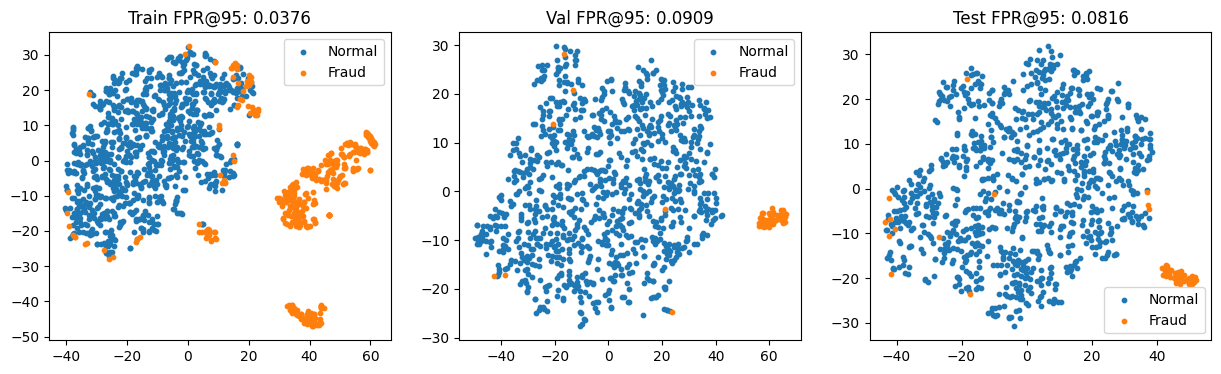

In [44]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.scatter(z_train_2d[y_train == 0, 0], z_train_2d[y_train == 0, 1], s=10, label='Normal')
plt.scatter(z_train_2d[y_train == 1, 0], z_train_2d[y_train == 1, 1], s=10, label='Fraud')
plt.title(f'Train FPR@95: {train_fpr:.4f}')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(z_val_2d[y_val == 0, 0], z_val_2d[y_val == 0, 1], s=10, label='Normal')
plt.scatter(z_val_2d[y_val == 1, 0], z_val_2d[y_val == 1, 1], s=10, label='Fraud')
plt.title(f'Val FPR@95: {val_fpr:.4f}')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(z_test_2d[y_test == 0, 0], z_test_2d[y_test == 0, 1], s=10, label='Normal')
plt.scatter(z_test_2d[y_test == 1, 0], z_test_2d[y_test == 1, 1], s=10, label='Fraud')
plt.title(f'Test FPR@95: {test_fpr:.4f}')
plt.legend()
plt.show()

# Training DeepSAD-Mahalanobis

In [45]:
config = {
    'method': 'sad-maha',
    'eta': 100.,
    
    # Training
    'epochs': 1000,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'patience': 20,
    'min_delta': 1e-8,
    'sched_patience': 10,
    'sched_factor': 0.5,
    
    # Network
    'dims' : [30, 16, 16, 8],
    'drop': None,
    'norm': True,
    'activation': 'LeakyReLU',
    
    # Dataset
    'val_split': 0.1,
    'test_split': 0.1,
    'batch_size': 1024,
    
    # Utility
    'seed': 15,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_path': './Data/creditcard.csv',
    'print_freq': 20,
}

In [46]:
train_loader, val_loader, test_loader = get_loaders(config['data_path'], config['val_split'], config['test_split'], config['seed'], config['batch_size'], config['method'])

(230693, 31) (25633, 31) (28481, 31)


In [47]:
if config['method'] == 'ssd':
    model = SSLNet(config).to(config['device'])
else:
    model = DeepSAD(config).to(config['device'])
print(model)
config['seed'] = 15

DeepSAD(
  (embeddings): Sequential(
    (0): Linear(in_features=30, out_features=16, bias=False)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=16, out_features=16, bias=False)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=16, out_features=8, bias=False)
  )
)


In [48]:
model, train_losses, val_losses, _, _, _, _ = train(model, train_loader, val_loader, config)

Epoch 1 | Train Loss: 5.5341 | Val Loss: 3.6020 | Train AUPRC: 0.1586 | Val AUPRC: 0.2486 | Train FPR@95TPR: 0.1429 | Val FPR@95TPR: 0.0682 | Best Epoch: 0
Epoch 20 | Train Loss: 0.2441 | Val Loss: 0.2360 | Train AUPRC: 0.6583 | Val AUPRC: 0.7956 | Train FPR@95TPR: 0.0852 | Val FPR@95TPR: 0.0909 | Best Epoch: 17
Epoch 40 | Train Loss: 0.1765 | Val Loss: 0.2904 | Train AUPRC: 0.6987 | Val AUPRC: 0.8081 | Train FPR@95TPR: 0.0501 | Val FPR@95TPR: 0.0909 | Best Epoch: 20
Early stopping
Epoch 40 | Train Loss: 0.1765 | Val Loss: 0.2904 | Train AUPRC: 0.6987 | Val AUPRC: 0.8081 | Train FPR@95TPR: 0.0501 | Val FPR@95TPR: 0.0909 | Best Epoch: 20
Training completed in 2m 11s


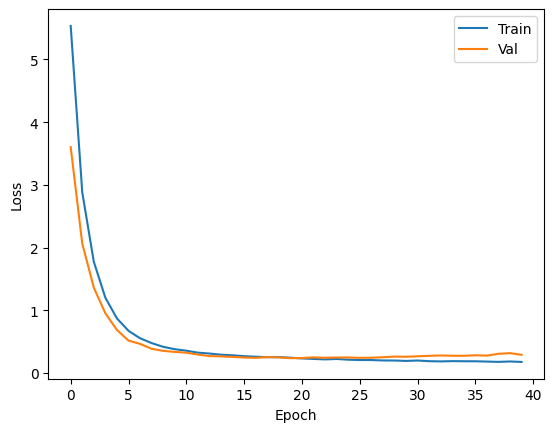

In [49]:
# Plot the loss
plt.plot(train_losses, label = "Train")
plt.plot(val_losses, label = "Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [50]:
train_ap, train_fpr, train_roc = evaluate(model, train_loader, train_loader, config['method'])
val_ap, val_fpr, val_roc = evaluate(model, train_loader, val_loader, config['method'])
test_ap, test_fpr, test_roc = evaluate(model, train_loader, test_loader, config['method'])

print(f'Train FPR@95: {train_fpr:.4f}, Val FPR@95: {val_fpr:.4f}, Test FPR@95: {test_fpr:.4f}')
print(f'Train AUPRC: {train_ap:.4f}, Val AUPRC: {val_ap:.4f}, Test AUPRC: {test_ap:.4f}')
print(f'Train ROC: {train_roc:.4f}, Val ROC: {val_roc:.4f}, Test ROC: {test_roc:.4f}')

Train FPR@95: 0.0526, Val FPR@95: 0.0909, Test FPR@95: 0.0816
Train AUPRC: 0.7006, Val AUPRC: 0.8077, Test AUPRC: 0.7531
Train ROC: 0.9931, Val ROC: 0.9784, Test ROC: 0.9760


In [51]:
# Get embeddings
z_train, y_train = get_features(model, train_loader)
z_val, y_val = get_features(model, val_loader)
z_test, y_test = get_features(model, test_loader)

# Sample only 1000 points from normal, but all frauds
n_train = pd.DataFrame(z_train[y_train == 0])
n_val = pd.DataFrame(z_val[y_val == 0])
n_test = pd.DataFrame(z_test[y_test == 0])

n_train = n_train.sample(1000, random_state=15)
n_val = n_val.sample(1000, random_state=15)
n_test = n_test.sample(1000, random_state=15)

z_train = pd.concat([n_train, pd.DataFrame(z_train[y_train == 1])], axis=0).values
z_val = pd.concat([n_val, pd.DataFrame(z_val[y_val == 1])], axis=0).values
z_test = pd.concat([n_test, pd.DataFrame(z_test[y_test == 1])], axis=0).values

y_train = np.concatenate([np.zeros(1000), np.ones(z_train.shape[0] - 1000)])
y_val = np.concatenate([np.zeros(1000), np.ones(z_val.shape[0] - 1000)])
y_test = np.concatenate([np.zeros(1000), np.ones(z_test.shape[0] - 1000)])

# TSNE
z_train_2d = TSNE(n_components=2).fit_transform(z_train)
z_val_2d = TSNE(n_components=2).fit_transform(z_val)
z_test_2d = TSNE(n_components=2).fit_transform(z_test)

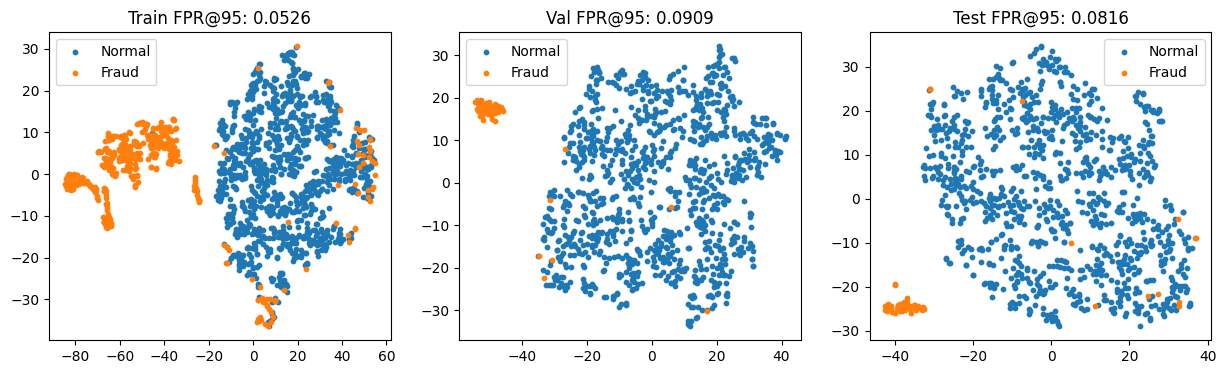

In [52]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.scatter(z_train_2d[y_train == 0, 0], z_train_2d[y_train == 0, 1], s=10, label='Normal')
plt.scatter(z_train_2d[y_train == 1, 0], z_train_2d[y_train == 1, 1], s=10, label='Fraud')
plt.title(f'Train FPR@95: {train_fpr:.4f}')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(z_val_2d[y_val == 0, 0], z_val_2d[y_val == 0, 1], s=10, label='Normal')
plt.scatter(z_val_2d[y_val == 1, 0], z_val_2d[y_val == 1, 1], s=10, label='Fraud')
plt.title(f'Val FPR@95: {val_fpr:.4f}')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(z_test_2d[y_test == 0, 0], z_test_2d[y_test == 0, 1], s=10, label='Normal')
plt.scatter(z_test_2d[y_test == 1, 0], z_test_2d[y_test == 1, 1], s=10, label='Fraud')
plt.title(f'Test FPR@95: {test_fpr:.4f}')
plt.legend()
plt.show()

# Training SSD

In [32]:
config = {
    'method': 'ssd',
    'temperature': 0.05,
    'contrast_mode': 'one',
    
    # Training
    'epochs': 1000,
    'lr': 1e-4,
    'weight_decay': 1e-6,
    'patience': 20,
    'min_delta': 1e-8,
    'sched_patience': 10,
    'sched_factor': 0.5,
    
    # Network
    'dims' : [30, 16, 8],
    'drop': None,
    'norm': True,
    'activation': 'ReLU',
    
    # Dataset
    'val_split': 0.1,
    'test_split': 0.1,
    'batch_size': 1024,
    
    # Utility
    'seed': 15,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_path': './Data/creditcard.csv',
    'print_freq': 20,
}

In [33]:
train_loader, val_loader, test_loader = get_loaders(config['data_path'], config['val_split'], config['test_split'], config['seed'], config['batch_size'], config['method'])

(230693, 31) (25633, 31) (28481, 31)


In [34]:
if config['method'] == 'ssd':
    model = SSLNet(config).to(config['device'])
else:
    model = DeepSAD(config).to(config['device'])
print(model)

config['temperature'] = 0.05
config['seed'] = 15

SSLNet(
  (embeddings): Sequential(
    (0): Linear(in_features=30, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
)


In [35]:
model, train_losses, val_losses, _, _, _, _ = train(model, train_loader, val_loader, config)

Epoch 1 | Train Loss: 1.7128 | Val Loss: 1.2474 | Train AUPRC: 0.5307 | Val AUPRC: 0.6422 | Train FPR@95TPR: 0.0977 | Val FPR@95TPR: 0.0909 | Best Epoch: 0
Epoch 20 | Train Loss: 0.7120 | Val Loss: 0.6863 | Train AUPRC: 0.3266 | Val AUPRC: 0.3720 | Train FPR@95TPR: 0.2005 | Val FPR@95TPR: 0.1136 | Best Epoch: 19
Epoch 40 | Train Loss: 0.6893 | Val Loss: 0.6680 | Train AUPRC: 0.1111 | Val AUPRC: 0.2179 | Train FPR@95TPR: 0.3434 | Val FPR@95TPR: 0.1591 | Best Epoch: 39
Epoch 60 | Train Loss: 0.6802 | Val Loss: 0.6608 | Train AUPRC: 0.0476 | Val AUPRC: 0.1046 | Train FPR@95TPR: 0.4812 | Val FPR@95TPR: 0.2955 | Best Epoch: 58
Epoch 80 | Train Loss: 0.6775 | Val Loss: 0.6569 | Train AUPRC: 0.0518 | Val AUPRC: 0.0867 | Train FPR@95TPR: 0.5238 | Val FPR@95TPR: 0.3182 | Best Epoch: 77
Epoch 100 | Train Loss: 0.6741 | Val Loss: 0.6530 | Train AUPRC: 0.0718 | Val AUPRC: 0.1039 | Train FPR@95TPR: 0.5063 | Val FPR@95TPR: 0.3182 | Best Epoch: 97
Epoch 120 | Train Loss: 0.6725 | Val Loss: 0.6498 | T

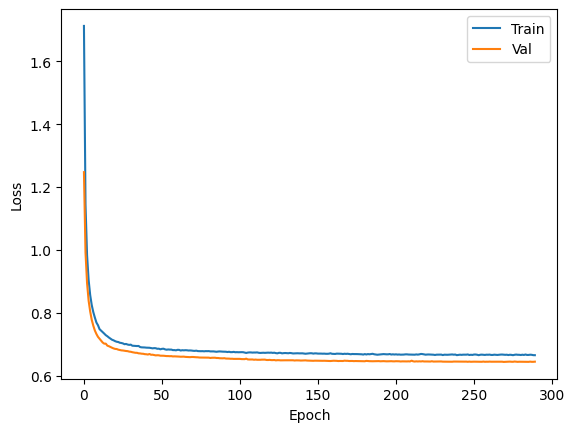

In [36]:
# Plot the loss
plt.plot(train_losses, label = "Train")
plt.plot(val_losses, label = "Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [37]:
train_ap, train_fpr, train_roc = evaluate(model, train_loader, train_loader, config['method'])
val_ap, val_fpr, val_roc = evaluate(model, train_loader, val_loader, config['method'])
test_ap, test_fpr, test_roc = evaluate(model, train_loader, test_loader, config['method'])

print(f'Train FPR@95: {train_fpr:.4f}, Val FPR@95: {val_fpr:.4f}, Test FPR@95: {test_fpr:.4f}')
print(f'Train AUPRC: {train_ap:.4f}, Val AUPRC: {val_ap:.4f}, Test AUPRC: {test_ap:.4f}')
print(f'Train ROC: {train_roc:.4f}, Val ROC: {val_roc:.4f}, Test ROC: {test_roc:.4f}')

Train FPR@95: 0.4110, Val FPR@95: 0.2955, Test FPR@95: 0.4286
Train AUPRC: 0.0537, Val AUPRC: 0.0672, Test AUPRC: 0.0624
Train ROC: 0.8983, Val ROC: 0.9272, Test ROC: 0.9219


In [38]:
# Get embeddings
z_train, y_train = get_features(model, train_loader)
z_val, y_val = get_features(model, val_loader)
z_test, y_test = get_features(model, test_loader)

# Sample only 1000 points from normal, but all frauds
n_train = pd.DataFrame(z_train[y_train == 0])
n_val = pd.DataFrame(z_val[y_val == 0])
n_test = pd.DataFrame(z_test[y_test == 0])

n_train = n_train.sample(1000, random_state=15)
n_val = n_val.sample(1000, random_state=15)
n_test = n_test.sample(1000, random_state=15)

z_train = pd.concat([n_train, pd.DataFrame(z_train[y_train == 1])], axis=0).values
z_val = pd.concat([n_val, pd.DataFrame(z_val[y_val == 1])], axis=0).values
z_test = pd.concat([n_test, pd.DataFrame(z_test[y_test == 1])], axis=0).values

y_train = np.concatenate([np.zeros(1000), np.ones(z_train.shape[0] - 1000)])
y_val = np.concatenate([np.zeros(1000), np.ones(z_val.shape[0] - 1000)])
y_test = np.concatenate([np.zeros(1000), np.ones(z_test.shape[0] - 1000)])

# TSNE
z_train_2d = TSNE(n_components=2).fit_transform(z_train)
z_val_2d = TSNE(n_components=2).fit_transform(z_val)
z_test_2d = TSNE(n_components=2).fit_transform(z_test)

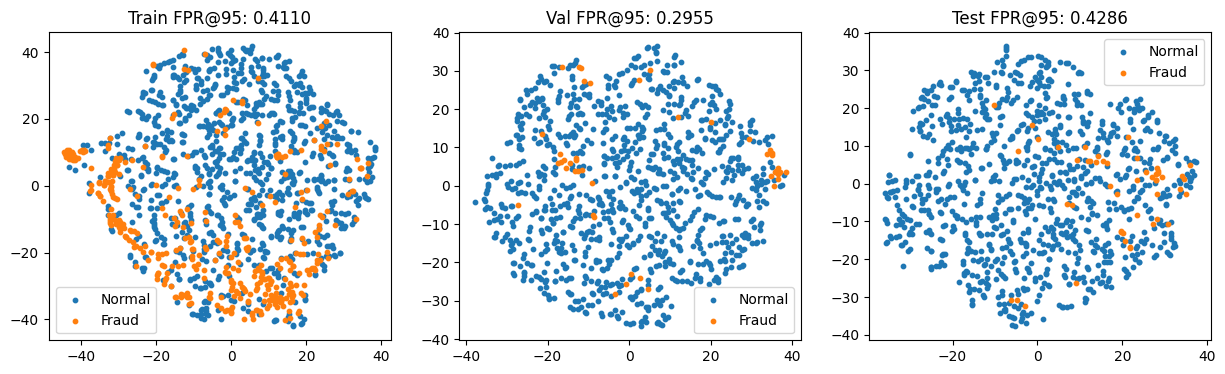

In [39]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.scatter(z_train_2d[y_train == 0, 0], z_train_2d[y_train == 0, 1], s=10, label='Normal')
plt.scatter(z_train_2d[y_train == 1, 0], z_train_2d[y_train == 1, 1], s=10, label='Fraud')
plt.title(f'Train FPR@95: {train_fpr:.4f}')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(z_val_2d[y_val == 0, 0], z_val_2d[y_val == 0, 1], s=10, label='Normal')
plt.scatter(z_val_2d[y_val == 1, 0], z_val_2d[y_val == 1, 1], s=10, label='Fraud')
plt.title(f'Val FPR@95: {val_fpr:.4f}')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(z_test_2d[y_test == 0, 0], z_test_2d[y_test == 0, 1], s=10, label='Normal')
plt.scatter(z_test_2d[y_test == 1, 0], z_test_2d[y_test == 1, 1], s=10, label='Fraud')
plt.title(f'Test FPR@95: {test_fpr:.4f}')
plt.legend()
plt.show()